<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Computer%20Vision/Animal_image_using_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import numpy as np 
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

getting train and validation images path

In [ ]:
image_paths = glob.glob('/content/animals/animals/**/*.jpg', recursive=True)

image_labels=pd.Series([x.split("/")[-2] for x in image_paths])


In [ ]:
df=pd.DataFrame({"Paths":image_paths,"Labels":image_labels})

In [ ]:
df.head()

,Paths,Labels
0,/content/animals/animals/owl/01cd839271.jpg,owl
1,/content/animals/animals/owl/8ee28cd014.jpg,owl
2,/content/animals/animals/owl/6d8c9d7ab1.jpg,owl
3,/content/animals/animals/owl/8a322a9315.jpg,owl
4,/content/animals/animals/owl/731ce5d441.jpg,owl


In [ ]:
df.Labels.value_counts()

owl             60
koala           60
hippopotamus    60
dog             60
bison           60
                ..
starfish        60
rhinoceros      60
goose           60
antelope        60
kangaroo        60
Name: Labels, Length: 90, dtype: int64

In [ ]:
print("Number of training and validation images:",df.shape[0])

Number of training and validation images: 5400


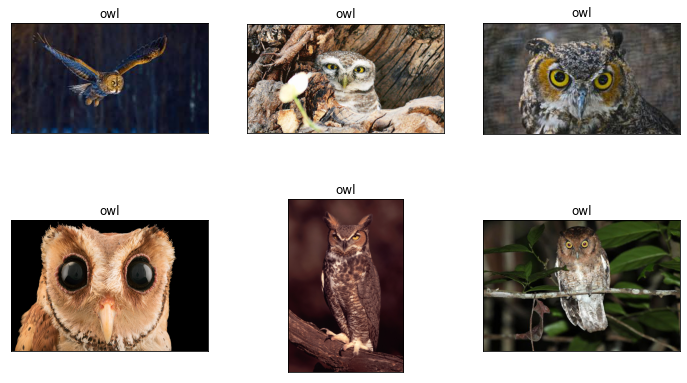

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):    
    ax.imshow(plt.imread(df["Paths"].iloc[idx]))
    ax.set_title(df["Labels"].iloc[idx])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Paths'], df['Labels'],
                                                    test_size=0.2, random_state=42)

# Create a dataframe for the training data
df = pd.DataFrame({'Paths': X_train, 'Labels': y_train})

# Create a dataframe for the test data
df_test = pd.DataFrame({'Paths': X_test, 'Labels': y_test})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
#It is useful to augment the data in order to avoid overfitting. It is also useful considering that there aren't a lot of images in both train and validation set.
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input, width_shift_range=0.1, 
                                   height_shift_range=0.1,zoom_range=0.2,brightness_range=[0.2,1.0],validation_split=0.1)
test_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [ ]:
BATCH_SIZE=64
train_images=train_datagen.flow_from_dataframe(dataframe=df,x_col='Paths',y_col='Labels',color_mode='rgb',class_mode='categorical',
                                                target_size=(224, 224),batch_size=BATCH_SIZE,shuffle=True,seed=1234,subset='training')

val_images=train_datagen.flow_from_dataframe(dataframe=df,x_col='Paths',y_col='Labels',color_mode='rgb',class_mode='categorical',
                                                target_size=(224, 224),batch_size=BATCH_SIZE,shuffle=True,seed=1234,subset='validation')

test_images = test_datagen.flow_from_dataframe(dataframe=df_test,x_col='Paths',y_col='Labels',color_mode='rgb',class_mode='categorical',
                                                target_size=(224, 224),batch_size=BATCH_SIZE,shuffle=False)

Found 3888 validated image filenames belonging to 90 classes.
Found 432 validated image filenames belonging to 90 classes.
Found 1080 validated image filenames belonging to 90 classes.


In [ ]:
inputs = tf.keras.layers.Input((224,224,3))
base_model=tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=(224, 224,3), pooling='max') 
base_model.trainable = False
x=base_model(inputs)
x = layers.Dense(256,activation='relu')(x) 
x=layers.Dropout(rate=.5)(x)  
output=layers.Dense(90, activation='softmax')(x)
model=tf.keras.models.Model(inputs=inputs, outputs=output)


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 90)                23130     
                                                                 
Total params: 21,409,154
Trainable params: 547,674
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps=10000,decay_rate=1e-6)
model.compile(Adamax(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, validation_data=val_images, epochs=10)

Epoch 1/10
61/61 [==============================] - 864s 14s/step - loss: 3.7759 - accuracy: 0.1965 - val_loss: 2.4498 - val_accuracy: 0.5509
Epoch 2/10
61/61 [==============================] - 859s 14s/step - loss: 2.2161 - accuracy: 0.4915 - val_loss: 1.3377 - val_accuracy: 0.7245
Epoch 3/10
61/61 [==============================] - 858s 14s/step - loss: 1.5343 - accuracy: 0.6330 - val_loss: 1.0008 - val_accuracy: 0.7569
Epoch 4/10
61/61 [==============================] - 856s 14s/step - loss: 1.2415 - accuracy: 0.6947 - val_loss: 0.8354 - val_accuracy: 0.8102
Epoch 5/10
61/61 [==============================] - 854s 14s/step - loss: 1.0724 - accuracy: 0.7281 - val_loss: 0.7809 - val_accuracy: 0.7986
Epoch 6/10
61/61 [==============================] - 853s 14s/step - loss: 0.9634 - accuracy: 0.7515 - val_loss: 0.7323 - val_accuracy: 0.8171
Epoch 7/10
61/61 [==============================] - 852s 14s/step - loss: 0.9260 - accuracy: 0.7652 - val_loss: 0.6862 - val_accuracy: 0.8241
Epoch 

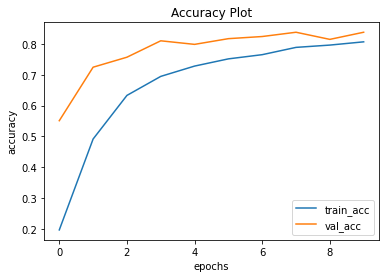

In [ ]:
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title('Accuracy Plot')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

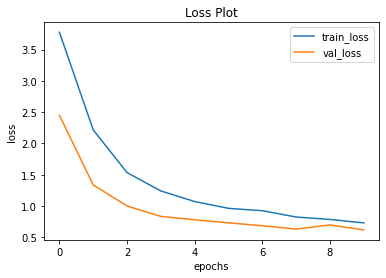

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title('Loss Plot')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
#predicts the test images and converts to labels 
pred=model.predict(test_images)
pred = np.argmax(pred,axis=1)
pred=pred>0.5
gt=[0 if x=="African" else 1 for x in df_test["Labels"]]

17/17 [==============================] - 226s 13s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(gt,pred))

In [ ]:
conf_matrix = confusion_matrix(gt, pred)
sns.heatmap(conf_matrix,xticklabels = ["African","Asian"], yticklabels = ["African","Asian"],annot=True)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
probs=pd.DataFrame({"Probs":model.predict(test_images)[:,0]})
# dataframe that contain bad predictions
bad_preds=df_test[gt!=pred].sample(frac=1,random_state=1234).reset_index(drop = True)
# dataframe that contain good predictions
good_preds=df_test[gt==pred].sample(frac=1,random_state=1234).reset_index(drop = True)


17/17 [==============================] - 204s 12s/step


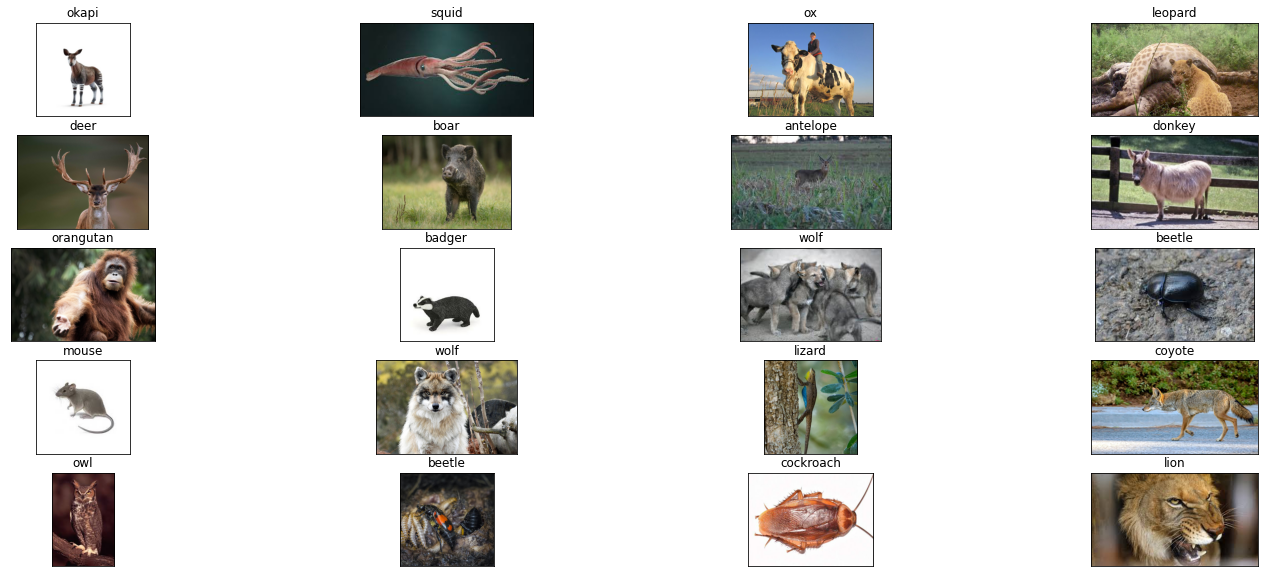

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):    
    ax.imshow(plt.imread(good_preds["Paths"].iloc[idx]))
    ax.set_title(good_preds["Labels"].iloc[idx])
plt.show()